## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Fri May 20 17:26:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:B1:00.0 Off |                  N/A |
|  0%   31C    P8     8W / 250W |      3MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(50):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.log(total_loss / len(train_dataset))
        val_loss = np.log(val_loss / len(val_dataset))

        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 17.963930479939172 val_loss: 14.584459099625137
epoch 1 train_loss: 13.438651535648951 val_loss: 12.349846828564603
epoch 2 train_loss: 12.051769768019902 val_loss: 11.941606332857244
epoch 3 train_loss: 11.857019957215646 val_loss: 11.826712996068528
epoch 4 train_loss: 11.809718334721028 val_loss: 11.803559780264283
epoch 5 train_loss: 11.79210096273483 val_loss: 11.807636990035828
epoch 6 train_loss: 11.782044771883303 val_loss: 11.801319844188503
epoch 7 train_loss: 11.774535663458053 val_loss: 11.795464758841721
epoch 8 train_loss: 11.765106092558085 val_loss: 11.81280628045145
epoch 9 train_loss: 11.753145439729169 val_loss: 11.841124374769892
epoch 10 train_loss: 11.740133361166183 val_loss: 11.867505431521277
epoch 11 train_loss: 11.728924004940817 val_loss: 11.882868023599299
epoch 12 train_loss: 11.719075653613519 val_loss: 11.879265081320236
epoch 13 train_loss: 11.708039721135371 val_loss: 11.869204390347953
epoch 14 train_loss: 11.694039310

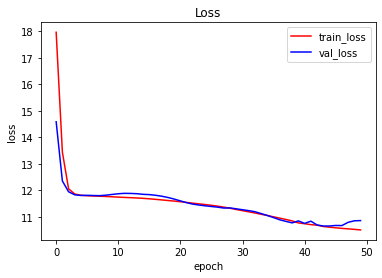

city: miami
epoch 0 train_loss: 19.455409680148247 val_loss: 14.461678253966069
epoch 1 train_loss: 13.18652133646385 val_loss: 12.16248636498212
epoch 2 train_loss: 11.939922714756987 val_loss: 11.787688257315695
epoch 3 train_loss: 11.74589227131155 val_loss: 11.670996200096729
epoch 4 train_loss: 11.663350534125748 val_loss: 11.627033948343495
epoch 5 train_loss: 11.615949509458055 val_loss: 11.57080647478613
epoch 6 train_loss: 11.578636559852862 val_loss: 11.527258110307866


KeyboardInterrupt: 

In [7]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=2e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
    pickle.dump(pred, open('models/ta_model_baseline_' + city, 'wb'))

In [8]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('models/ta_model_baseline_' + city, 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [9]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-31.452484,-562.548340,-33.952343,-565.756409,-32.007393,-564.075317,-30.762920,-563.210083,-31.028749,...,-31.905733,-564.923950,-32.423668,-565.540039,-32.022629,-564.601624,-32.312786,-565.114441,-35.172150,-567.413391
1,1_austin,-351.348969,-0.119122,-350.579590,0.138293,-349.517548,0.117330,-351.175507,-2.667399,-348.796692,...,-351.217377,-4.216088,-349.444855,1.408106,-347.734467,0.657192,-353.903961,-2.523358,-352.531555,-3.875669
2,2_austin,52.536083,-247.152374,52.810318,-246.935181,52.799950,-247.529129,52.189980,-247.396378,52.836784,...,53.448818,-247.667999,53.442268,-247.301743,52.962234,-247.433365,53.182888,-247.676529,53.037708,-247.476486
3,3_austin,-106.558907,1803.800537,-105.225006,1802.591431,-104.679924,1800.107422,-106.711349,1798.814697,-106.220612,...,-98.779205,1801.653442,-103.487602,1800.609985,-102.373840,1803.712036,-102.916985,1799.536621,-102.170425,1802.438843
4,4_austin,1230.415649,-646.340393,1228.973511,-644.798462,1229.457275,-643.078735,1231.996826,-644.133118,1231.857666,...,1231.125122,-641.399292,1232.445557,-644.789551,1230.611938,-642.621582,1231.720337,-645.117065,1231.885620,-640.346008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1385.287231,-460.426483,-1380.776733,-461.190033,-1380.695679,-462.279510,-1384.988525,-461.701294,-1383.289429,...,-1368.622192,-469.239227,-1379.109741,-455.256287,-1376.202026,-466.640106,-1363.880127,-459.745361,-1375.023804,-463.403198
29839,1682_palo-alto,128.678925,-37.629963,129.935883,-38.154217,129.317322,-37.539192,128.578171,-37.556068,128.766876,...,129.638794,-37.775154,130.258606,-35.779835,128.943008,-36.716232,129.099106,-36.260242,129.076157,-37.493565
29840,1683_palo-alto,-1450.032471,2170.785889,-1451.728516,2174.138672,-1447.593018,2174.030518,-1450.204956,2171.910400,-1451.995361,...,-1444.619385,2177.399170,-1445.512207,2177.559814,-1445.637939,2177.074951,-1447.102295,2174.739746,-1446.107178,2176.353760
29841,1684_palo-alto,1048.192139,1382.367310,1046.368164,1398.683350,1048.355347,1384.482910,1051.488770,1388.268311,1055.826416,...,1044.473389,1392.719727,1047.746948,1390.432129,1051.738647,1399.739868,1042.208130,1396.866577,1051.914917,1390.431641


In [10]:
all_predictions.to_csv('out.csv', index=False)

In [ ]:
pd.read_csv('out.csv')